# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Согласно технической документации ниже приведена расшифровка признаков в датасете.

* DateCrawled — дата скачивания анкеты из базы

* VehicleType — тип автомобильного кузова

* RegistrationYear — год регистрации автомобиля

* Gearbox — тип коробки передач

* Power — мощность (л. с.)

* Model — модель автомобиля

* Kilometer — пробег (км)

* RegistrationMonth — месяц регистрации автомобиля

* FuelType — тип топлива

* Brand — марка автомобиля

* Repaired — была машина в ремонте или нет

* DateCreated — дата создания анкеты

* NumberOfPictures — количество фотографий автомобиля

* PostalCode — почтовый индекс владельца анкеты (пользователя)

* LastSeen — дата последней активности пользователя

* Price — цена (евро)

Произведем импорт всех необходимых библиотек

In [1]:
!pip install lightgbm

In [2]:
#! pip install git+https://github.com/optuna/optuna.git

In [3]:
import pandas as pd
import random as rn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import catboost as cb
import lightgbm as lgbm

import optuna

/Users/alekseikurylev/Desktop/conda_env_1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sns.set(rc={"figure.figsize":(15, 9)})
sns.set_style("darkgrid")

## Подготовка данных

На данном этапе произведем выгрузку данных и изучим их более подробно.

In [5]:
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [6]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Согласно выгрузке и предствавленным данным мы видим следующее:

1) В столбцах VehicleType, Gearbox, Model, FuelType, Repaired имеются пропущенные значения.

2) В столбце NumberOfPictures количество фотографий равно 0, что достаточно странно. 

3) В столбце RegistrationYear имеются аномальные значения. Как мимимум 1000 и 9999 год регистрации.

4) В столбце Price имеется аномальное значение 0.

5) В столбце Power имеется аномальное значение 0.

6) В столбце RegistrationMonth имеется аномальное значение 0.

In [9]:
df.columns = df.columns.str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True).str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

### Проверка дубликатов

#### Явные дубликаты

Проверим на наличие явных дубликатов в датасете.df.duplicated().sum()

In [10]:
df.duplicated().sum()

4

Избавимся от явных дубликатов.

In [11]:
df = df.drop_duplicates().reset_index(drop=True)

#### Неявные дубликаты, замена на пропусков  в категориальных признаках.

Попробуем проверить наличие неявных дубликатов. Для этого сконцентрируем внимание на столбцах с типом данных object:

- VehicleType
- Gearbox
- Model
- FuelType
- Brand
- Repaired

Проверим наличие уникальных значений.

In [12]:
df['vehicle_type'].value_counts()

vehicle_type
sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: count, dtype: int64

In [13]:
df['vehicle_type'].isna().sum()

37490

In [14]:
df.isna().mean()['vehicle_type']

0.10579487251844849

Учитывая, что пропущенных значений порядка 10 %, а данные по машинам достаточно сильно различаются, поэтму пропущенные значения заполним  типом кузова other.

In [15]:
df['vehicle_type'] = df['vehicle_type'].fillna('other')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354365 non-null  object
 1   price               354365 non-null  int64 
 2   vehicle_type        354365 non-null  object
 3   registration_year   354365 non-null  int64 
 4   gearbox             334532 non-null  object
 5   power               354365 non-null  int64 
 6   model               334660 non-null  object
 7   kilometer           354365 non-null  int64 
 8   registration_month  354365 non-null  int64 
 9   fuel_type           321470 non-null  object
 10  brand               354365 non-null  object
 11  repaired            283211 non-null  object
 12  date_created        354365 non-null  object
 13  number_of_pictures  354365 non-null  int64 
 14  postal_code         354365 non-null  int64 
 15  last_seen           354365 non-null  object
dtypes:

In [16]:
df['gearbox'].value_counts()

gearbox
manual    268249
auto       66283
Name: count, dtype: int64

In [17]:
isna_gear_ratio = df['gearbox'].isna().sum()/len(df['gearbox'])
isna_gear_ratio

0.05596771690206426

Количсество пропусков составляет 5%. Можно предположить, что помимо механической или автоматической коробки передач еще существуют вариатор и роботизированная КПП. Вероятно, на сайте опции выбора альтернативных КПП нет, поэтому добавим 3-й тип other в замен пропусков.

In [18]:
df['gearbox'] = df['gearbox'].fillna('other')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354365 non-null  object
 1   price               354365 non-null  int64 
 2   vehicle_type        354365 non-null  object
 3   registration_year   354365 non-null  int64 
 4   gearbox             354365 non-null  object
 5   power               354365 non-null  int64 
 6   model               334660 non-null  object
 7   kilometer           354365 non-null  int64 
 8   registration_month  354365 non-null  int64 
 9   fuel_type           321470 non-null  object
 10  brand               354365 non-null  object
 11  repaired            283211 non-null  object
 12  date_created        354365 non-null  object
 13  number_of_pictures  354365 non-null  int64 
 14  postal_code         354365 non-null  int64 
 15  last_seen           354365 non-null  object
dtypes:

In [19]:
df['model'].value_counts()

model
golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: count, Length: 250, dtype: int64

In [20]:
isna_model_ratio = df['model'].isna().sum()/len(df['model'])
isna_model_ratio

0.05560650741467131

Учитывая, что колличество пропусков по моделям составляет 5%, можно предположить, что часть моделей еще не внесено в базу данных сайта. Поэтому можно также заменить все пропуски на other.

In [21]:
df['model'] = df['model'].fillna('other')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354365 non-null  object
 1   price               354365 non-null  int64 
 2   vehicle_type        354365 non-null  object
 3   registration_year   354365 non-null  int64 
 4   gearbox             354365 non-null  object
 5   power               354365 non-null  int64 
 6   model               354365 non-null  object
 7   kilometer           354365 non-null  int64 
 8   registration_month  354365 non-null  int64 
 9   fuel_type           321470 non-null  object
 10  brand               354365 non-null  object
 11  repaired            283211 non-null  object
 12  date_created        354365 non-null  object
 13  number_of_pictures  354365 non-null  int64 
 14  postal_code         354365 non-null  int64 
 15  last_seen           354365 non-null  object
dtypes:

In [22]:
df['fuel_type'].value_counts()

fuel_type
petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64

В данных подозрительно выглядят 2 типа топлива petrol и gasoline, так как оба слова при переводе с английского являются бензином. Можно предложить данный фактор в различии страны производства: США или Европа, Россия, Азия. Проверим данную гипотезу.

In [23]:
df.loc[df['fuel_type'] == 'petrol'].head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58


In [24]:
df.loc[df['fuel_type'] == 'petrol'].tail()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
354354,2016-04-04 09:57:12,1490,small,1998,manual,50,lupo,150000,9,petrol,volkswagen,no,2016-04-04 00:00:00,0,48653,2016-04-06 11:17:13
354358,2016-03-19 19:53:49,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,2016-03-19 00:00:00,0,96465,2016-03-19 20:44:43
354359,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
354360,2016-03-21 09:50:58,0,other,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354362,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12


Написание на английском не зависит от региона. Поэтому можно переименовать gasoline в petrol и проверим наличие пропусков.

In [25]:
df.loc[df['fuel_type'] == 'gasoline', 'fuel_type'] = 'petrol' 

isna_fuel_ratio = df['fuel_type'].isna().sum()/len(df['fuel_type'])
isna_fuel_ratio

0.09282801631086592

Количество пропусков составляет 10%. Учитывая, что вариантов топлива может быть много, то пропущенные значения заполним типом other.

In [26]:
df['fuel_type'] = df['fuel_type'].fillna('other')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354365 non-null  object
 1   price               354365 non-null  int64 
 2   vehicle_type        354365 non-null  object
 3   registration_year   354365 non-null  int64 
 4   gearbox             354365 non-null  object
 5   power               354365 non-null  int64 
 6   model               354365 non-null  object
 7   kilometer           354365 non-null  int64 
 8   registration_month  354365 non-null  int64 
 9   fuel_type           354365 non-null  object
 10  brand               354365 non-null  object
 11  repaired            283211 non-null  object
 12  date_created        354365 non-null  object
 13  number_of_pictures  354365 non-null  int64 
 14  postal_code         354365 non-null  int64 
 15  last_seen           354365 non-null  object
dtypes:

In [27]:
df['brand'].value_counts()

brand
volkswagen        77012
opel              39931
bmw               36914
mercedes_benz     32044
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2322
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: count, dtype: int64

Пропущенных значений в столбце Brand нет, что видно из инфомрации выше.

Перейдем к признаку Repaired

In [28]:
df['repaired'].value_counts()

repaired
no     247158
yes     36053
Name: count, dtype: int64

In [29]:
isna_repaired_ratio = df['repaired'].isna().sum()/len(df['repaired'])
isna_repaired_ratio

0.2007929677027923

Из данных видно, что у нас всего два значения: yes и no. Количество пропусков составляет 20%.

Рассмотрим, как распределяются машины  в зависимости от пробега при условии ремонта.

Text(0, 0.5, 'Факт ремонта')

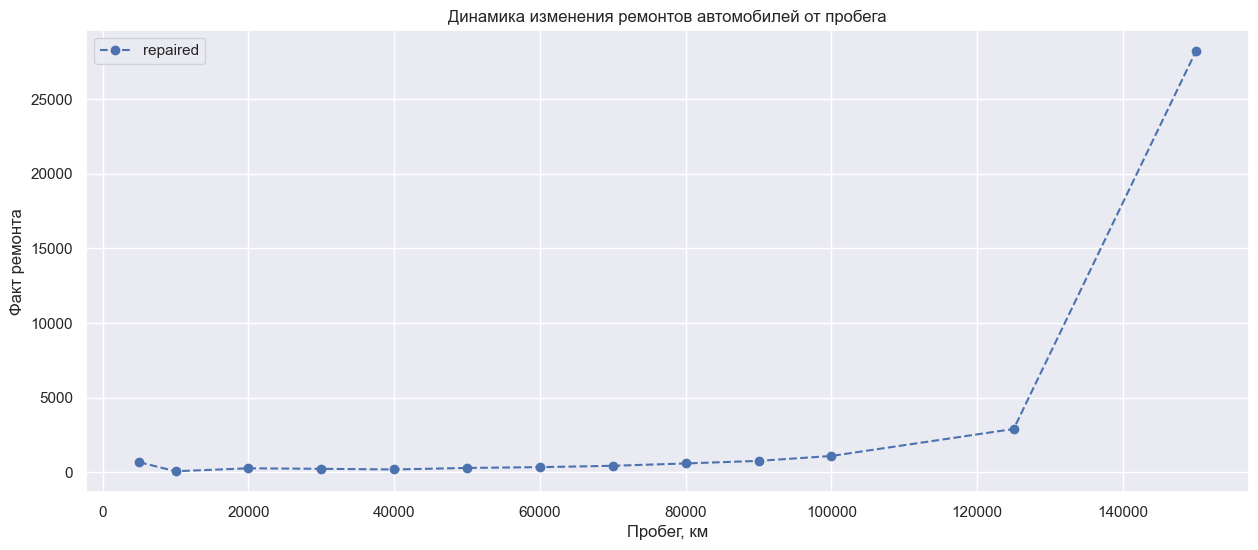

In [30]:
df.loc[df['repaired'] == 'yes'].pivot_table(index='kilometer', values='repaired', aggfunc='count').plot(style='o--', figsize=(15, 6), grid=True)

plt.title('Динамика изменения ремонтов автомобилей от пробега')
plt.xlabel('Пробег, км')
plt.ylabel('Факт ремонта')

Из графика мы видим, что автомобилей с пробегом более 120 000 км, у которых был ремонт, значительно выростает. 

Отсюда можно предложить следующую замену пропущенных значений:
 
1) Если пробег > 120 000 км, то, вероятно, был ремонт.

2) Если пробег < 120 000 км, то, вероятно, ремонт не производился.

In [31]:
df['repaired'] = df['repaired'].fillna(df['kilometer'] > 120000)
df.loc[df['repaired'] == True, 'repaired'] = 'yes'
df.loc[df['repaired'] == False, 'repaired'] = 'no'
df['repaired'].value_counts()

repaired
no     260055
yes     94310
Name: count, dtype: int64

### Исследовательский анализ, проверка на аномальные значения.

Рассмотрим, какие у нас встречаются аномальные значения в числовых признаках.

**Признак - Price**

Для начала расмотрим столбец с ценой Price.

<Axes: >

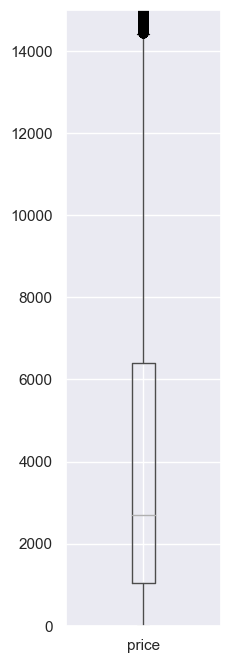

In [32]:
plt.figure(figsize=(2, 8))
plt.ylim(0,15000)
df.boxplot('price')

<Axes: >

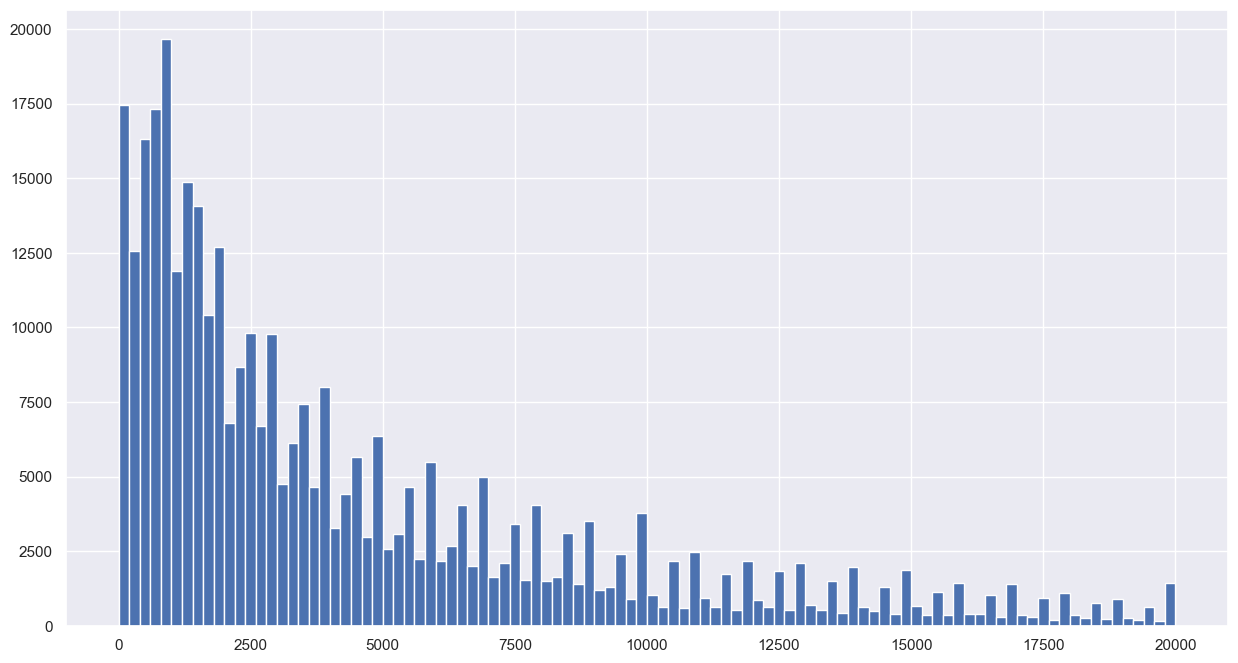

In [33]:
plt.figure(figsize=(15, 8))
df['price'].hist(bins=100, range =(0,20000))

На основании представленных диаграмм мы видим, что имеется аномальное значение стоимости автомобиля - 0 Евро. Посмотрим, какие значения приведены в строках с нулевой ценой.

In [34]:
df.loc[df['price'] == 0].head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,other,1990,other,0,corsa,150000,1,petrol,opel,yes,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,other,2017,manual,0,golf,5000,12,petrol,volkswagen,no,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,other,0,other,5000,0,petrol,volkswagen,no,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
154,2016-03-22 16:37:59,0,other,2006,other,0,other,5000,0,other,fiat,no,2016-03-22 00:00:00,0,44867,2016-04-06 06:17:56
231,2016-03-16 22:06:24,0,wagon,2001,manual,115,mondeo,150000,0,other,ford,yes,2016-03-16 00:00:00,0,57627,2016-03-26 11:17:50
334,2016-03-06 10:06:20,0,other,2005,other,0,polo,150000,0,petrol,volkswagen,yes,2016-03-06 00:00:00,0,35392,2016-03-07 19:12:00
415,2016-03-11 10:52:49,0,other,1985,other,0,3er,150000,0,other,bmw,yes,2016-03-11 00:00:00,0,85051,2016-03-11 11:41:09
466,2016-03-24 10:58:40,0,other,2016,auto,197,3er,150000,12,petrol,bmw,no,2016-03-24 00:00:00,0,99867,2016-03-25 19:46:09


In [35]:
zero_price = df.loc[df['price'] == 0, 'price'].count()/df['price'].count()
zero_price
#df['Price'].count()

0.030398035923412302

Доля нулевых цен составляет 3%. При этом автомобили с нулевой ценой различаются по типу кузова , году выпуска, типу коробки передач, Пробегу и тд. Поэтому заменить 0 цену медианой, среденей или случайной будет не корректно. 

Учитывая, что доля данных машин незначительна, избавимся от них. В качестве нижнего порога возьмем стоимость машины 400 Евро.

In [36]:
df = df.loc[df['price'] >=400]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 324346 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        324346 non-null  object
 1   price               324346 non-null  int64 
 2   vehicle_type        324346 non-null  object
 3   registration_year   324346 non-null  int64 
 4   gearbox             324346 non-null  object
 5   power               324346 non-null  int64 
 6   model               324346 non-null  object
 7   kilometer           324346 non-null  int64 
 8   registration_month  324346 non-null  int64 
 9   fuel_type           324346 non-null  object
 10  brand               324346 non-null  object
 11  repaired            324346 non-null  object
 12  date_created        324346 non-null  object
 13  number_of_pictures  324346 non-null  int64 
 14  postal_code         324346 non-null  int64 
 15  last_seen           324346 non-null  object
dtypes: int6

**Год регистрации автомобиля - RegistrationYear**

<Axes: >

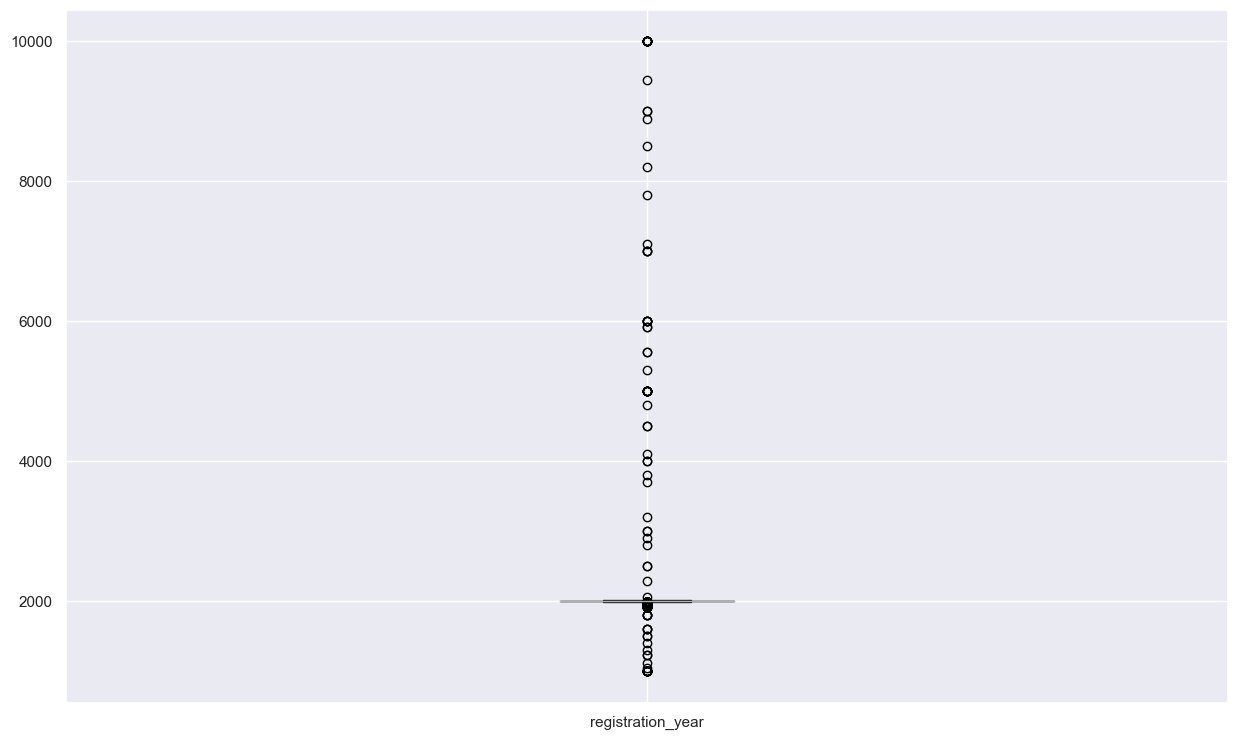

In [37]:
#plt.figure(figsize=(2, 8))
#plt.ylim(1900,2022)
df.boxplot('registration_year')

Количество выбросов очень большое. Рассмотрим диаграмму размаха с периода 1900 по 2022 год и далее при необходимости будем сужать данный диапазон.

<Axes: >

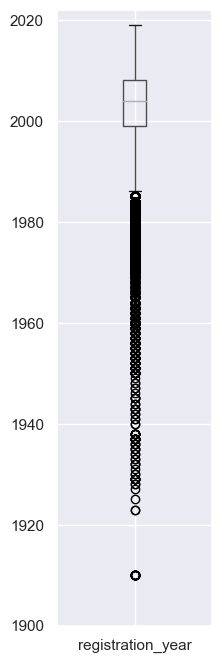

In [38]:
plt.figure(figsize=(2, 8))
plt.ylim(1900,2022)
df.boxplot('registration_year')

<Axes: >

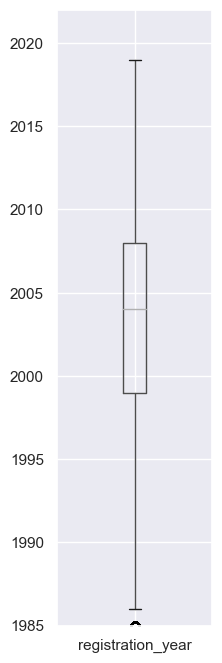

In [39]:
plt.figure(figsize=(2, 8))
plt.ylim(1985
         ,2022)
df.boxplot('registration_year')

<Axes: >

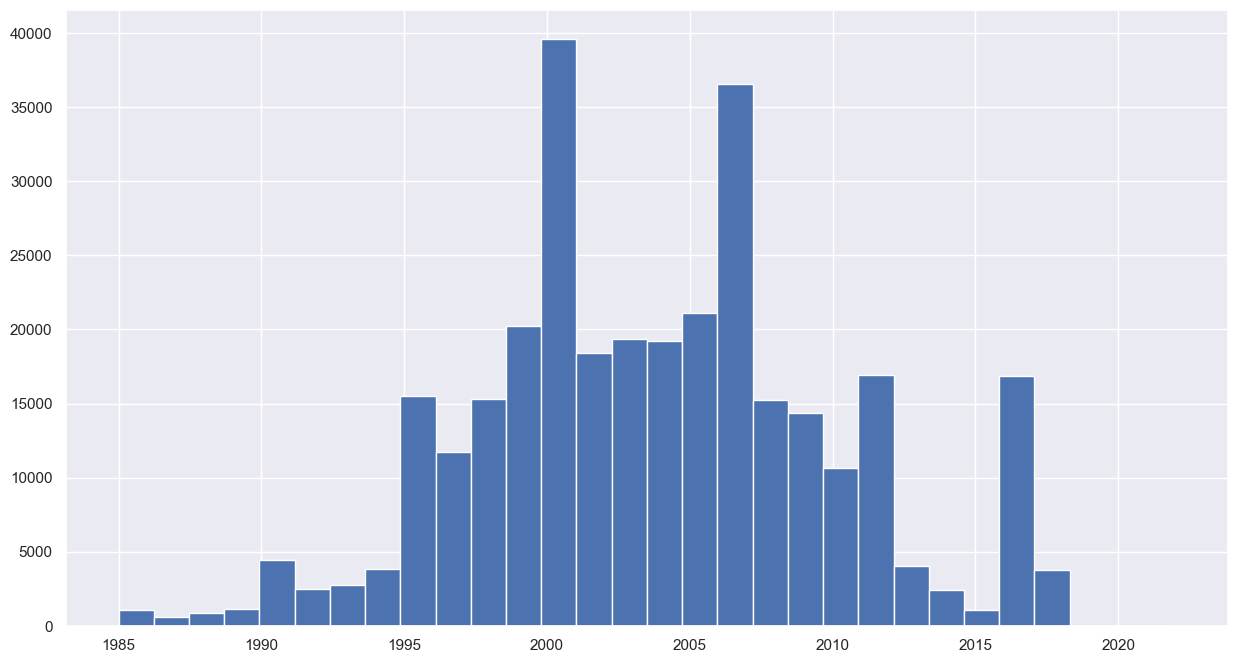

In [40]:
plt.figure(figsize=(15, 8))
df['registration_year'].hist(bins=30, range =(1985,2022))

Как видно графиков, основной объем машин распределенс с 1985 по 2020 год. Остальных машин незначительное количество, поэтому от них можно избавиться.

Для выбора верхнего предела по годам автомобилей будем ориентироваться на признак даты создания анкеты DateCreated.

In [41]:
df_year= pd.DatetimeIndex(df['date_created']).year
df_year.max()

2016

Самая свежая анкета датируется 2016 годом, поэтому в качестве ограничителя сверху будем использовать данное значение.

In [42]:
df = df[(df['registration_year'] >= 1985) & (df['registration_year'] <= 2016)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306326 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        306326 non-null  object
 1   price               306326 non-null  int64 
 2   vehicle_type        306326 non-null  object
 3   registration_year   306326 non-null  int64 
 4   gearbox             306326 non-null  object
 5   power               306326 non-null  int64 
 6   model               306326 non-null  object
 7   kilometer           306326 non-null  int64 
 8   registration_month  306326 non-null  int64 
 9   fuel_type           306326 non-null  object
 10  brand               306326 non-null  object
 11  repaired            306326 non-null  object
 12  date_created        306326 non-null  object
 13  number_of_pictures  306326 non-null  int64 
 14  postal_code         306326 non-null  int64 
 15  last_seen           306326 non-null  object
dtypes: int6

**Мощность - Power**

<Axes: >

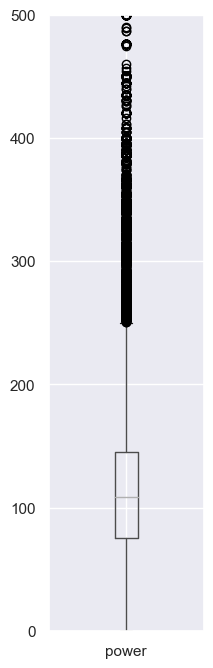

In [43]:
plt.figure(figsize=(2, 8))
plt.ylim(0,500)
df.boxplot('power')

<Axes: >

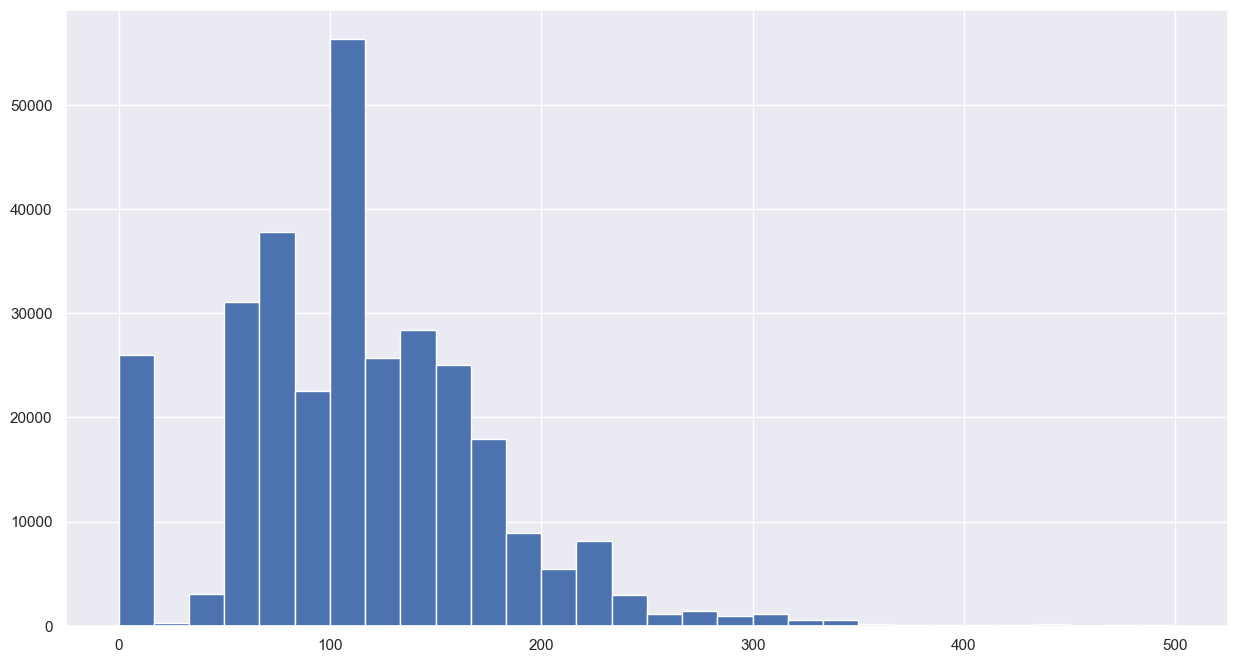

In [44]:
plt.figure(figsize=(15, 8))
df['power'].hist(bins=30, range =(0,500))

Из графика видно, что имеется аномальное значение 0 л.с. Проверим долю, данных машин.

In [45]:
zero_power = df.loc[df['power'] == 0, 'power'].count()/df['power'].count()
zero_power

0.08414564875328898

Дополнительно проверим долю автомобилей с мощностью более 500.

more_power = df.loc[df['Power'] > 500, 'Power'].count()/df['Power'].count()
more_powerКоличество автомоблиелей с 0 мощностью составляет порядка 10%, что значительно. 

Также имеется автомобиль с мощностью 20 000 л.с., что по сути является аномальным значением. При этом стоит отметить, что доля автомобилей с мощностью более 500 л.с. является незначительной

Учитывая, что все автомобили отличаются между собой по маркам, моделям, году выпуска, и т.д., заменим 0 л.с. на случайные значения мощности из диапазона 69 - 143 л.с. А в качестве диапазона мощности возьмем с 69 - 500 л.с.

In [46]:
rand_power = rn.randint(69, 143)
df['power']= df['power'].replace(to_replace=0, method='ffill')

df = df[(df['power'] >= 69)& (df['power'] <= 500)]

df['power'].describe()

count    264709.000000
mean        132.785493
std          50.029207
min          69.000000
25%         101.000000
50%         122.000000
75%         155.000000
max         500.000000
Name: power, dtype: float64

**Признак - RegistrationMonth**

In [47]:
df['registration_month'].value_counts(ascending=False)

registration_month
3     26386
6     24434
4     22715
5     22568
7     21078
10    20466
11    19205
0     19031
12    18845
9     18646
8     17673
1     17518
2     16144
Name: count, dtype: int64

<Axes: >

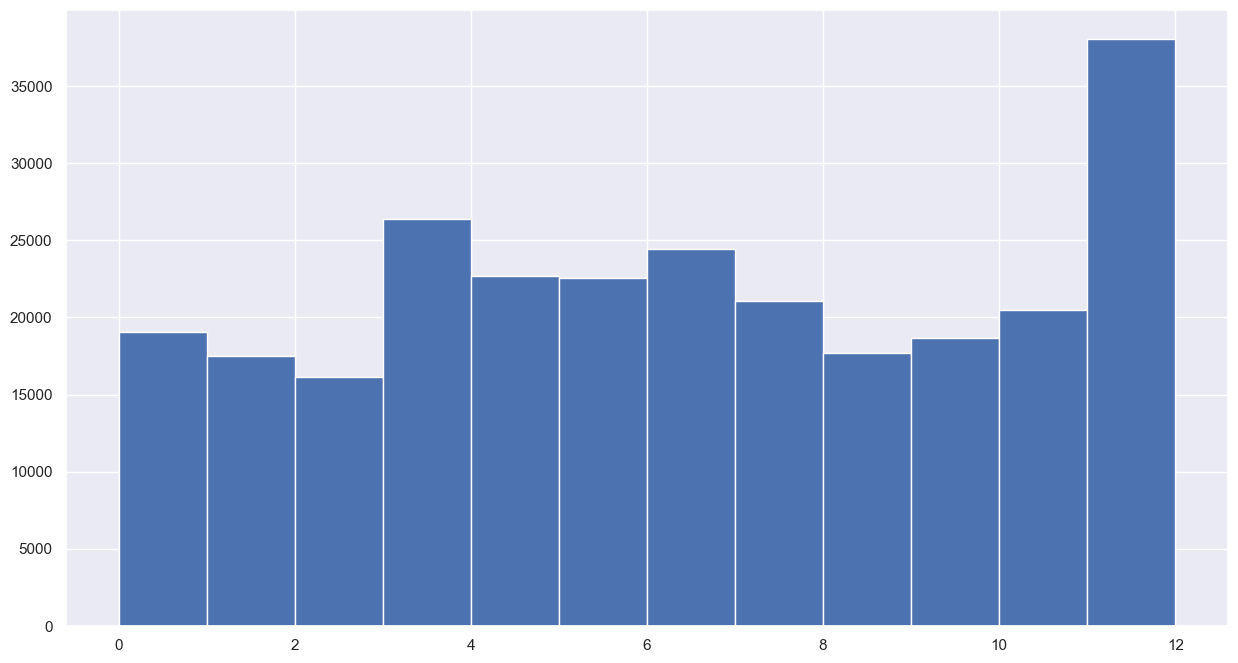

In [48]:
plt.figure(figsize=(15, 8))
df['registration_month'].hist(bins=12, range =(0,12))

Распределение по месяцам имеет отностительно равномерное распределение, за исключением декабря месяца.

Также видно, что имеется аномальный месяц 0. Можно предположить, что это ошибка в заполнении анкеты и прокуск самим хозяином анкеты.

Учитывая данное распределение, заменим 0 случайными числами от 1 до 12.

In [49]:
df['registration_month']= df['registration_month'].replace(to_replace=0, method='ffill')

rand_month = rn.randint(1, 12)
#df.loc[df['RegistrationMonth'] == 0, 'RegistrationMonth'] = rand_month
df['registration_month'].value_counts(ascending=False)

registration_month
3     28431
6     26290
4     24470
5     24256
7     22678
10    22058
11    20773
12    20279
9     20126
8     19059
1     18906
2     17383
Name: count, dtype: int64

Дополнительно отметим, что фотографий в признаке NumberOfPictures нет. Учитывая, что фотографий нет, данный признак нам не пригодится в дальнейшем исседовании.

Выведем итоговую инфомрацию по предобработанному датасету.

In [50]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,petrol,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,yes,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 264709 entries, 1 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        264709 non-null  object
 1   price               264709 non-null  int64 
 2   vehicle_type        264709 non-null  object
 3   registration_year   264709 non-null  int64 
 4   gearbox             264709 non-null  object
 5   power               264709 non-null  int64 
 6   model               264709 non-null  object
 7   kilometer           264709 non-null  int64 
 8   registration_month  264709 non-null  int64 
 9   fuel_type           264709 non-null  object
 10  brand               264709 non-null  object
 11  repaired            264709 non-null  object
 12  date_created        264709 non-null  object
 13  number_of_pictures  264709 non-null  int64 
 14  postal_code         264709 non-null  int64 
 15  last_seen           264709 non-null  object
dtypes: int6

In [52]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,264709.000000,264709.000000,264709.000000,264709.000000,264709.000000,264709.0,264709.000000
mean,5288.203435,2003.515339,132.785493,129217.480327,6.424595,0.0,51375.343385
std,4654.896607,5.703321,50.029207,36485.358337,3.345899,0.0,25819.369281
min,400.000000,1985.000000,69.000000,5000.000000,1.000000,0.0,1067.000000
25%,1650.000000,2000.000000,101.000000,125000.000000,4.000000,0.0,30952.000000
50%,3699.000000,2004.000000,122.000000,150000.000000,6.000000,0.0,50374.000000
75%,7600.000000,2007.000000,155.000000,150000.000000,9.000000,0.0,72229.000000
max,20000.000000,2016.000000,500.000000,150000.000000,12.000000,0.0,99998.000000


### Вывод по предобработке данных.

Проведена предобработка исходного датасета. Произведена очистка от всех аномальных значений, заполнены пропуски в категориальных и колличественных признаках.

## Обучение моделей

Разделим на обучающую и тестовую выборку.

In [53]:
learn = df[['price', 'vehicle_type', 'registration_year', 
                     'gearbox', 'power', 'model', 'kilometer', 
                     'fuel_type', 'brand']]

X = learn[['vehicle_type', 'registration_year', 
                     'gearbox', 'power', 'model', 'kilometer', 
                     'fuel_type', 'brand']]
y = learn['price']

RANDOM_STATE = 42

Сначала разделим данные на обучающую и тестовую выборки в соотношении 80% на 20%.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=RANDOM_STATE, 
                                                    shuffle=True)

Теперь выделим из учебной выборки 20 процентов на валидацию.

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, 
                                                  random_state=RANDOM_STATE, 
                                                  shuffle=True)

**Catboost**

In [56]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 
                'brand']

In [57]:
train_dataset = cb.Pool(X_train, y_train, cat_features=cat_features) 
test_dataset = cb.Pool(X_test, y_test, cat_features=cat_features)

In [58]:
val_dataset = cb.Pool(X_val, y_val, cat_features=cat_features)

In [59]:
cb_model = cb.CatBoostRegressor(
    loss_function='RMSE',
    random_seed=RANDOM_STATE,
    verbose=False
)

In [60]:
grid = {'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 8]}


In [61]:
%%time
grid_search_result  = cb_model.grid_search(grid, train_dataset)


bestTest = 2051.976177
bestIteration = 999

0:	loss: 2051.9761767	best: 2051.9761767 (0)	total: 7.21s	remaining: 36.1s

bestTest = 1943.512809
bestIteration = 999

1:	loss: 1943.5128094	best: 1943.5128094 (1)	total: 13.9s	remaining: 27.8s

bestTest = 1890.927097
bestIteration = 999

2:	loss: 1890.9270968	best: 1890.9270968 (2)	total: 27.4s	remaining: 27.4s

bestTest = 1820.304035
bestIteration = 999

3:	loss: 1820.3040345	best: 1820.3040345 (3)	total: 41s	remaining: 20.5s

bestTest = 1777.764462
bestIteration = 999

4:	loss: 1777.7644621	best: 1777.7644621 (4)	total: 1m 7s	remaining: 13.4s

bestTest = 1729.83166
bestIteration = 999

5:	loss: 1729.8316600	best: 1729.8316600 (5)	total: 2m 43s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 1720.2423
bestIteration = 993

Training on fold [1/3]

bestTest = 1703.451299
bestIteration = 999

Training on fold [2/3]

bestTest = 1718.84943
bestIteration = 989

CPU times: user 25min 57s, sys: 2min 26s, total: 28min 

Модель CatBoost на кросс-валидации обеспечила метрику RMSE 1703 за 3 минуты 19 секунд. Посмотрим, какое значение RMSE модель выдаст на валидационных данных.

In [62]:
cb_predict = cb_model.predict(val_dataset)

In [63]:
mean_squared_error(y_val, cb_predict, squared=False)

1688.589971122577

Заказчику важно время обучения и время предсказаний модели. Чтобы замерить это время обучим модель на валидационной выборке, а затем получим предсказания на ней же.

In [64]:
grid_search_result['params']

{'depth': 8, 'learning_rate': 0.1}

In [65]:
cb_model_val = cb.CatBoostRegressor(
    loss_function='RMSE',
    random_seed=RANDOM_STATE,
    depth=8,
    learning_rate=0.1,
    verbose=100
)

In [66]:
%%time
cb_model_val.fit(val_dataset)

0:	learn: 4348.4499257	total: 11.1ms	remaining: 11s
100:	learn: 1821.9433334	total: 922ms	remaining: 8.21s
200:	learn: 1716.5348805	total: 1.87s	remaining: 7.45s
300:	learn: 1655.5356241	total: 2.85s	remaining: 6.61s
400:	learn: 1606.6561547	total: 3.81s	remaining: 5.68s
500:	learn: 1568.9351576	total: 4.76s	remaining: 4.74s
600:	learn: 1542.5616371	total: 5.73s	remaining: 3.8s
700:	learn: 1516.5571982	total: 6.71s	remaining: 2.86s
800:	learn: 1494.4107561	total: 7.7s	remaining: 1.91s
900:	learn: 1473.0941127	total: 8.65s	remaining: 950ms
999:	learn: 1453.7475332	total: 9.6s	remaining: 0us
CPU times: user 54.7 s, sys: 9.19 s, total: 1min 3s
Wall time: 9.76 s


In [67]:
%%time
cb_model_val.predict(val_dataset)

CPU times: user 301 ms, sys: 4.99 ms, total: 306 ms
Wall time: 41.6 ms


array([1150.38558315, 9604.42551012, 8729.53705943, ..., 1665.41321419,
       4692.8844713 , 1628.50521191])

Модель на основе CatBoost обучалась 8 секунд, время предсказаний составило 65.6 миллисекунд.

**LightGBM**

In [68]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()
X_val_lgbm = X_val.copy()

In [69]:
for feature in cat_features:
    X_train_lgbm[feature] = pd.Series(X_train_lgbm[feature], dtype='category')
    X_test_lgbm[feature] = pd.Series(X_test_lgbm[feature], dtype='category')
    X_val_lgbm[feature] = pd.Series(X_val_lgbm[feature], dtype='category')

In [70]:
def objective(trial):
    X_train_l, X_val_l, y_train_l, y_val_l = train_test_split(X_train_lgbm, y_train, test_size = 0.2)
    dtrain = lgbm.Dataset(X_train_l, label=y_train_l)

    param = {
      'metric': 'root_mean_squared_error',
      'random_state': RANDOM_STATE,
      'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.1),
      'max_depth': trial.suggest_int('max_depth', 2, 8),
      }

    gbm = lgbm.train(param, dtrain)
    y_pred_l = gbm.predict(X_val_l)
    rmse = mean_squared_error(y_val_l, y_pred_l, squared=False)
    return rmse

In [71]:
%%time
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2023-05-13 18:45:57,229] A new study created in memory with name: no-name-a942845e-63a2-4392-a27e-30f8fea9a95a


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5282.525050


[I 2023-05-13 18:45:57,589] Trial 0 finished with value: 1794.1667758153258 and parameters: {'learning_rate': 0.0679064348693338, 'max_depth': 6}. Best is trial 0 with value: 1794.1667758153258.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5287.161706


[I 2023-05-13 18:45:57,926] Trial 1 finished with value: 1805.723985200593 and parameters: {'learning_rate': 0.05989300106773948, 'max_depth': 6}. Best is trial 0 with value: 1794.1667758153258.
[I 2023-05-13 18:45:58,091] Trial 2 finished with value: 2149.297740991022 and parameters: {'learning_rate': 0.05444451583981038, 'max_depth': 2}. Best is trial 0 with value: 1794.1667758153258.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5297.451361
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 135530, n

[I 2023-05-13 18:45:58,688] Trial 3 finished with value: 1761.6205475479983 and parameters: {'learning_rate': 0.09599866438362444, 'max_depth': 8}. Best is trial 3 with value: 1761.6205475479983.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5284.288497


[I 2023-05-13 18:45:59,338] Trial 4 finished with value: 1781.8824536539075 and parameters: {'learning_rate': 0.05056460984820353, 'max_depth': 7}. Best is trial 3 with value: 1761.6205475479983.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5271.762923


[I 2023-05-13 18:45:59,705] Trial 5 finished with value: 1957.5722791481692 and parameters: {'learning_rate': 0.06321875435441379, 'max_depth': 3}. Best is trial 3 with value: 1761.6205475479983.
[I 2023-05-13 18:45:59,914] Trial 6 finished with value: 2184.1452951777173 and parameters: {'learning_rate': 0.050444356409407295, 'max_depth': 2}. Best is trial 3 with value: 1761.6205475479983.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5288.486114
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 135530, n

[I 2023-05-13 18:46:00,575] Trial 7 finished with value: 1750.2697586490378 and parameters: {'learning_rate': 0.07050422738682335, 'max_depth': 8}. Best is trial 7 with value: 1750.2697586490378.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5280.782971


[I 2023-05-13 18:46:00,928] Trial 8 finished with value: 1743.7595688853314 and parameters: {'learning_rate': 0.0679511266806165, 'max_depth': 8}. Best is trial 8 with value: 1743.7595688853314.
[I 2023-05-13 18:46:01,100] Trial 9 finished with value: 2246.286539018181 and parameters: {'learning_rate': 0.04222609724625541, 'max_depth': 2}. Best is trial 8 with value: 1743.7595688853314.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5294.093551
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5284.815059


[I 2023-05-13 18:46:01,366] Trial 10 finished with value: 1994.1365111668122 and parameters: {'learning_rate': 0.030020347629944613, 'max_depth': 4}. Best is trial 8 with value: 1743.7595688853314.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5287.489530


[I 2023-05-13 18:46:01,723] Trial 11 finished with value: 1750.9433077367303 and parameters: {'learning_rate': 0.07722599623052687, 'max_depth': 8}. Best is trial 8 with value: 1743.7595688853314.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5279.192186


[I 2023-05-13 18:46:02,064] Trial 12 finished with value: 1768.7792498519261 and parameters: {'learning_rate': 0.07643395520488344, 'max_depth': 7}. Best is trial 8 with value: 1743.7595688853314.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5293.718232


[I 2023-05-13 18:46:02,408] Trial 13 finished with value: 1741.320462498154 and parameters: {'learning_rate': 0.07440385495853673, 'max_depth': 8}. Best is trial 13 with value: 1741.320462498154.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5286.547923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2023-05-13 18:46:02,727] Trial 14 finished with value: 1786.5818536833197 and parameters: {'learning_rate': 0.08534102483234005, 'max_depth': 5}. Best is trial 13 with value: 1741.320462498154.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-05-13 18:46:03,059] Trial 15 finished with value: 1754.950179470968 and parameters: {'learning_rate': 0.08430730391607397, 'max_depth': 7}. Best is trial 13 with value: 1741.320462498154.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5289.766745


[I 2023-05-13 18:46:03,404] Trial 16 finished with value: 1776.7058944909122 and parameters: {'learning_rate': 0.0699073636121653, 'max_depth': 6}. Best is trial 13 with value: 1741.320462498154.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5280.428282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2023-05-13 18:46:03,884] Trial 17 finished with value: 1796.1251393504408 and parameters: {'learning_rate': 0.09891056347991106, 'max_depth': 5}. Best is trial 13 with value: 1741.320462498154.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5292.215421


[I 2023-05-13 18:46:04,367] Trial 18 finished with value: 1752.1095449377906 and parameters: {'learning_rate': 0.0603207747931999, 'max_depth': 8}. Best is trial 13 with value: 1741.320462498154.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5282.258991


[I 2023-05-13 18:46:04,787] Trial 19 finished with value: 1770.7819417418445 and parameters: {'learning_rate': 0.0767892107015397, 'max_depth': 7}. Best is trial 13 with value: 1741.320462498154.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5276.092408


[I 2023-05-13 18:46:05,202] Trial 20 finished with value: 1786.4435259857125 and parameters: {'learning_rate': 0.08825142426207071, 'max_depth': 6}. Best is trial 13 with value: 1741.320462498154.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5292.129610


[I 2023-05-13 18:46:05,550] Trial 21 finished with value: 1739.9712420260557 and parameters: {'learning_rate': 0.07127956103732638, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5289.194606


[I 2023-05-13 18:46:05,940] Trial 22 finished with value: 1770.4430565856762 and parameters: {'learning_rate': 0.06957552256433219, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5286.581355


[I 2023-05-13 18:46:06,301] Trial 23 finished with value: 1772.7357007270195 and parameters: {'learning_rate': 0.07470280700575894, 'max_depth': 7}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5287.384063


[I 2023-05-13 18:46:06,653] Trial 24 finished with value: 1774.214049911352 and parameters: {'learning_rate': 0.064927930976356, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5281.539165


[I 2023-05-13 18:46:07,030] Trial 25 finished with value: 1779.6702637905926 and parameters: {'learning_rate': 0.082068154714108, 'max_depth': 7}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5287.757995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2023-05-13 18:46:07,326] Trial 26 finished with value: 1851.6287140534032 and parameters: {'learning_rate': 0.07457718855864344, 'max_depth': 4}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5284.962672


[I 2023-05-13 18:46:07,694] Trial 27 finished with value: 1775.0754245224864 and parameters: {'learning_rate': 0.06508670293091867, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5285.961536


[I 2023-05-13 18:46:08,061] Trial 28 finished with value: 1752.6837963972669 and parameters: {'learning_rate': 0.0807190226146871, 'max_depth': 7}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5292.894946


[I 2023-05-13 18:46:08,400] Trial 29 finished with value: 1782.4831266229626 and parameters: {'learning_rate': 0.06855212037092911, 'max_depth': 6}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5272.914690


[I 2023-05-13 18:46:08,793] Trial 30 finished with value: 1784.1378928967515 and parameters: {'learning_rate': 0.08919591846764127, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5282.153398


[I 2023-05-13 18:46:09,215] Trial 31 finished with value: 1759.3702463230038 and parameters: {'learning_rate': 0.0705659192187403, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5283.787471


[I 2023-05-13 18:46:09,560] Trial 32 finished with value: 1754.0390808414609 and parameters: {'learning_rate': 0.07263094424001405, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5285.462045


[I 2023-05-13 18:46:09,940] Trial 33 finished with value: 1767.5158290549348 and parameters: {'learning_rate': 0.0663795484012862, 'max_depth': 7}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5292.030687


[I 2023-05-13 18:46:12,112] Trial 34 finished with value: 1764.6111309719736 and parameters: {'learning_rate': 0.07246305748575947, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5293.465956


[I 2023-05-13 18:46:12,660] Trial 35 finished with value: 1783.6835495774787 and parameters: {'learning_rate': 0.06097436397622548, 'max_depth': 7}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5290.012425


[I 2023-05-13 18:46:13,314] Trial 36 finished with value: 1805.5231828813694 and parameters: {'learning_rate': 0.05661033949929553, 'max_depth': 6}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5281.833387


[I 2023-05-13 18:46:14,045] Trial 37 finished with value: 1771.3701725329288 and parameters: {'learning_rate': 0.07940943996804625, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5282.614388


[I 2023-05-13 18:46:14,751] Trial 38 finished with value: 1804.4389593135925 and parameters: {'learning_rate': 0.0686343256802565, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5287.087899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-05-13 18:46:15,083] Trial 39 finished with value: 1856.9875025748775 and parameters: {'learning_rate': 0.06590518174128618, 'max_depth': 4}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5291.769689


[I 2023-05-13 18:46:15,797] Trial 40 finished with value: 1782.5570886556802 and parameters: {'learning_rate': 0.06210204844407454, 'max_depth': 6}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5292.141039


[I 2023-05-13 18:46:16,512] Trial 41 finished with value: 1769.258180033866 and parameters: {'learning_rate': 0.07696887759719007, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5291.647133


[I 2023-05-13 18:46:17,244] Trial 42 finished with value: 1742.4702713717716 and parameters: {'learning_rate': 0.07861664831052051, 'max_depth': 7}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5284.860326


[I 2023-05-13 18:46:17,934] Trial 43 finished with value: 1765.1176853750364 and parameters: {'learning_rate': 0.07943143349740092, 'max_depth': 7}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5278.625596


[I 2023-05-13 18:46:18,587] Trial 44 finished with value: 1781.2903124597622 and parameters: {'learning_rate': 0.0734331463454348, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5291.244189


[I 2023-05-13 18:46:19,237] Trial 45 finished with value: 1796.6858271147337 and parameters: {'learning_rate': 0.0708390705308032, 'max_depth': 7}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5286.767491


[I 2023-05-13 18:46:19,885] Trial 46 finished with value: 1767.202671493474 and parameters: {'learning_rate': 0.06674726453964064, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5292.305851


[I 2023-05-13 18:46:20,609] Trial 47 finished with value: 1765.0262419509309 and parameters: {'learning_rate': 0.057381493098935116, 'max_depth': 7}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5283.266517


[I 2023-05-13 18:46:21,282] Trial 48 finished with value: 1758.6381637077043 and parameters: {'learning_rate': 0.07512237414746505, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5283.702516


[I 2023-05-13 18:46:21,675] Trial 49 finished with value: 1933.4036365540774 and parameters: {'learning_rate': 0.06296591796237656, 'max_depth': 3}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5287.467365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2023-05-13 18:46:22,265] Trial 50 finished with value: 1800.8761223729057 and parameters: {'learning_rate': 0.07796737037093342, 'max_depth': 5}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-05-13 18:46:22,843] Trial 51 finished with value: 1780.5311041489535 and parameters: {'learning_rate': 0.07183133888438313, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5286.372810


[I 2023-05-13 18:46:23,439] Trial 52 finished with value: 1760.3051762767486 and parameters: {'learning_rate': 0.07636190551232053, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5287.291183


[I 2023-05-13 18:46:23,945] Trial 53 finished with value: 1768.2881408245019 and parameters: {'learning_rate': 0.08457863087824902, 'max_depth': 7}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5290.656770


[I 2023-05-13 18:46:24,578] Trial 54 finished with value: 1767.6657336451563 and parameters: {'learning_rate': 0.08195346785577644, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5289.708006


[I 2023-05-13 18:46:25,096] Trial 55 finished with value: 1777.0583954935319 and parameters: {'learning_rate': 0.06910166437716496, 'max_depth': 7}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5292.625242


[I 2023-05-13 18:46:25,570] Trial 56 finished with value: 1757.943037051132 and parameters: {'learning_rate': 0.07408662325565117, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5281.639785


[I 2023-05-13 18:46:26,151] Trial 57 finished with value: 1771.3538554727297 and parameters: {'learning_rate': 0.07798857948348328, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5271.122216


[I 2023-05-13 18:46:26,571] Trial 58 finished with value: 1792.337750174741 and parameters: {'learning_rate': 0.06404344431507797, 'max_depth': 7}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5280.017944


[I 2023-05-13 18:46:26,929] Trial 59 finished with value: 1764.711979841733 and parameters: {'learning_rate': 0.06752140376091435, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5275.650173


[I 2023-05-13 18:46:27,367] Trial 60 finished with value: 1794.2027405232627 and parameters: {'learning_rate': 0.07078170262979001, 'max_depth': 6}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5280.013348


[I 2023-05-13 18:46:27,787] Trial 61 finished with value: 1765.4424697254208 and parameters: {'learning_rate': 0.05920065150804913, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5288.576123


[I 2023-05-13 18:46:28,187] Trial 62 finished with value: 1779.5985065279133 and parameters: {'learning_rate': 0.07498798981385814, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5283.136154


[I 2023-05-13 18:46:28,671] Trial 63 finished with value: 1788.4329114178515 and parameters: {'learning_rate': 0.06421259200847024, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5293.530746


[I 2023-05-13 18:46:29,064] Trial 64 finished with value: 1772.772839676857 and parameters: {'learning_rate': 0.07256659577135834, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5276.588453


[I 2023-05-13 18:46:29,635] Trial 65 finished with value: 1774.675793940886 and parameters: {'learning_rate': 0.06756957874053154, 'max_depth': 7}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5267.775489


[I 2023-05-13 18:46:30,118] Trial 66 finished with value: 1799.6287782875427 and parameters: {'learning_rate': 0.052634970741121535, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5290.609474


[I 2023-05-13 18:46:30,476] Trial 67 finished with value: 1759.3474850866517 and parameters: {'learning_rate': 0.08151973864890275, 'max_depth': 7}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5287.314941


[I 2023-05-13 18:46:30,854] Trial 68 finished with value: 1764.1133389021154 and parameters: {'learning_rate': 0.07054138414779428, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5280.419140


[I 2023-05-13 18:46:31,208] Trial 69 finished with value: 1790.1737513534065 and parameters: {'learning_rate': 0.06158235545623085, 'max_depth': 7}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5289.416528


[I 2023-05-13 18:46:31,663] Trial 70 finished with value: 1745.64671356515 and parameters: {'learning_rate': 0.07546560350913578, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5288.010131


[I 2023-05-13 18:46:32,183] Trial 71 finished with value: 1742.998593612279 and parameters: {'learning_rate': 0.07313193012568503, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5292.438265


[I 2023-05-13 18:46:32,827] Trial 72 finished with value: 1748.2124769910636 and parameters: {'learning_rate': 0.07656215984209214, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5289.692120


[I 2023-05-13 18:46:33,358] Trial 73 finished with value: 1767.4917888930454 and parameters: {'learning_rate': 0.0746870437557043, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5281.975282


[I 2023-05-13 18:46:33,866] Trial 74 finished with value: 1764.975366818626 and parameters: {'learning_rate': 0.07911091090426144, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5294.664296


[I 2023-05-13 18:46:34,247] Trial 75 finished with value: 1768.6903208413219 and parameters: {'learning_rate': 0.07673855170006831, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5291.173179


[I 2023-05-13 18:46:34,590] Trial 76 finished with value: 1777.0790572285941 and parameters: {'learning_rate': 0.07092127168161527, 'max_depth': 7}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5284.031041


[I 2023-05-13 18:46:34,989] Trial 77 finished with value: 1766.2927910871213 and parameters: {'learning_rate': 0.07260166109554063, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5288.991633


[I 2023-05-13 18:46:35,346] Trial 78 finished with value: 1764.78049367947 and parameters: {'learning_rate': 0.06903210704191892, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5290.280351


[I 2023-05-13 18:46:35,694] Trial 79 finished with value: 1764.7681759326165 and parameters: {'learning_rate': 0.07576230204995454, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.
[I 2023-05-13 18:46:35,930] Trial 80 finished with value: 1928.829928172265 and parameters: {'learning_rate': 0.07292990496211813, 'max_depth': 3}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5284.056969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total B

[I 2023-05-13 18:46:36,277] Trial 81 finished with value: 1769.12333254754 and parameters: {'learning_rate': 0.07817412881604689, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5289.708862


[I 2023-05-13 18:46:36,620] Trial 82 finished with value: 1770.8530812966578 and parameters: {'learning_rate': 0.08035388865881048, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5286.854047


[I 2023-05-13 18:46:36,997] Trial 83 finished with value: 1764.4710021109613 and parameters: {'learning_rate': 0.08325413431850605, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5281.931012
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2023-05-13 18:46:37,313] Trial 84 finished with value: 1789.3497324804925 and parameters: {'learning_rate': 0.07364864289939133, 'max_depth': 5}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-05-13 18:46:37,664] Trial 85 finished with value: 1762.4187494049593 and parameters: {'learning_rate': 0.07606465995326095, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5285.285110


[I 2023-05-13 18:46:38,051] Trial 86 finished with value: 1791.5482728040643 and parameters: {'learning_rate': 0.06634250647511279, 'max_depth': 7}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5277.286424


[I 2023-05-13 18:46:38,395] Trial 87 finished with value: 1780.7421268686976 and parameters: {'learning_rate': 0.07773956693409333, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5290.238515


[I 2023-05-13 18:46:38,741] Trial 88 finished with value: 1776.0079223544747 and parameters: {'learning_rate': 0.08019683391900163, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5279.365993


[I 2023-05-13 18:46:39,123] Trial 89 finished with value: 1766.261265410188 and parameters: {'learning_rate': 0.06912229636550257, 'max_depth': 7}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5286.452645


[I 2023-05-13 18:46:39,466] Trial 90 finished with value: 1780.6144627263125 and parameters: {'learning_rate': 0.07412733457055018, 'max_depth': 7}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5293.130982


[I 2023-05-13 18:46:39,974] Trial 91 finished with value: 1758.8627623071666 and parameters: {'learning_rate': 0.07172323126236498, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5282.440803


[I 2023-05-13 18:46:40,370] Trial 92 finished with value: 1775.8481823605557 and parameters: {'learning_rate': 0.06578302385950258, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5284.511296


[I 2023-05-13 18:46:40,728] Trial 93 finished with value: 1791.2365670832241 and parameters: {'learning_rate': 0.06760643932798337, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.
[I 2023-05-13 18:46:40,895] Trial 94 finished with value: 2056.1222763673964 and parameters: {'learning_rate': 0.07600696476140524, 'max_depth': 2}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5279.548166
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 135530, n

[I 2023-05-13 18:46:41,264] Trial 95 finished with value: 1789.993912963806 and parameters: {'learning_rate': 0.06996609513429344, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5279.656445


[I 2023-05-13 18:46:41,619] Trial 96 finished with value: 1777.3195026133133 and parameters: {'learning_rate': 0.07868348586280745, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5299.151398


[I 2023-05-13 18:46:41,996] Trial 97 finished with value: 1758.2341758064088 and parameters: {'learning_rate': 0.0717645951625405, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5288.843120


[I 2023-05-13 18:46:42,475] Trial 98 finished with value: 1766.6987123594115 and parameters: {'learning_rate': 0.07430117601066025, 'max_depth': 8}. Best is trial 21 with value: 1739.9712420260557.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 135530, number of used features: 8
[LightGBM] [Info] Start training from score 5288.668797


[I 2023-05-13 18:46:42,819] Trial 99 finished with value: 1792.3306940143648 and parameters: {'learning_rate': 0.07704046441747256, 'max_depth': 7}. Best is trial 21 with value: 1739.9712420260557.


CPU times: user 5min 30s, sys: 56.9 s, total: 6min 27s
Wall time: 45.6 s


In [72]:
model_lgbm = lgbm.LGBMRegressor(random_state=RANDOM_STATE,
                                metric='root_mean_squared_error',
                                learning_rate=0.0956621333321235,
                                max_depth=7
                                )

In [73]:
%%time
model_lgbm.fit(X_train_lgbm, y_train)

CPU times: user 2.81 s, sys: 420 ms, total: 3.23 s
Wall time: 334 ms


LGBMRegressor(learning_rate=0.0956621333321235, max_depth=7,
              metric='root_mean_squared_error', random_state=42)

In [74]:
y_pred_lgbm = model_lgbm.predict(X_val_lgbm)

In [75]:
mean_squared_error(y_val, y_pred_lgbm, squared=False)

1756.4786944637276

На валидационной выборке LightGBM обеспечивает RMSE 1756. Для сравнения с другими моделями измерим время обучения и предсказания.

In [76]:
%%time
model_lgbm.fit(X_val_lgbm, y_val)

CPU times: user 1.42 s, sys: 179 ms, total: 1.6 s
Wall time: 174 ms


LGBMRegressor(learning_rate=0.0956621333321235, max_depth=7,
              metric='root_mean_squared_error', random_state=42)

In [77]:
%%time
model_lgbm.predict(X_val_lgbm)

CPU times: user 331 ms, sys: 24.3 ms, total: 356 ms
Wall time: 39.4 ms


array([1189.28818935, 9575.75972106, 9229.86462677, ..., 2581.28918605,
       5893.67533398, 1406.71500529])

Модель LightGBM обучилась за 356 миллисекунд, выдала предсказания за 371 миллисекунду.

Похоже, что модель на основе LightGBM обучается и предсказывает значительно быстрее своих конкурентов и лишь немного уступает модели CatBoost в точности предсказаний. Посчитаем для LightGBM значение метрики на тестовой выборке.

In [78]:
X_train_fin = pd.concat([X_train, X_val])
y_train_fin = pd.concat([y_train, y_val])

for feature in cat_features:
    X_train_fin[feature] = pd.Series(X_train_fin[feature], dtype='category')
    
model_lgbm.fit(X_train_fin, y_train_fin)


LGBMRegressor(learning_rate=0.0956621333321235, max_depth=7,
              metric='root_mean_squared_error', random_state=42)

In [79]:
%%time
y_pred_lgbm = model_lgbm.predict(X_test_lgbm)

CPU times: user 409 ms, sys: 23.3 ms, total: 432 ms
Wall time: 47.3 ms


In [80]:
mean_squared_error(y_test, y_pred_lgbm, squared=False)

1745.667744721115

**DummyModel**

Чтобы убедиться, что наши модели действительно работают, сравним их с "глупой" моделью, которая всегда будет предсказывать среднее значение цены.

In [81]:
model_d = DummyRegressor()

In [82]:
%%time
model_d.fit(X_train, y_train)

CPU times: user 3.05 ms, sys: 1.41 ms, total: 4.47 ms
Wall time: 509 µs


DummyRegressor()

In [83]:
%%time
y_pred_d = model_d.predict(X_test)

CPU times: user 3.38 ms, sys: 2.09 ms, total: 5.47 ms
Wall time: 648 µs


In [84]:
mean_squared_error(y_test, y_pred_d, squared=False)

4671.286324599215

Модель обучилась быстро, а вот значение метрики значительно хуже, чем у всех остальных моделей. А значит все наши модели обучились и прошли проверку на адекватность.

## Анализ моделей

По результатам анализа выше видно, что модель Catboost обучается и предсказывает быстрее, чем LGBMRegressor.

При этом скорость выполнения ячейки кода по команде %%time выше у LGBMRegressor. Более того следуюет отметить, что метрика RMSE также лучше у данной модели.

# Общий вывод

По результатам предобработки исходных данных и подготовке выборок для обучения и предсказания, лучше всего проявила себя модель LGBMRegressor. Целевая метрика RMSE (ниже 2500) достигнута.

Лучшие параметры LGBMRegressor: learning_rate=0.0956621333321235, max_depth=7,